# PyMC and Universal Samplers

* probabilistic programming langauges let you write down statistical formulas 

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.10.4


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

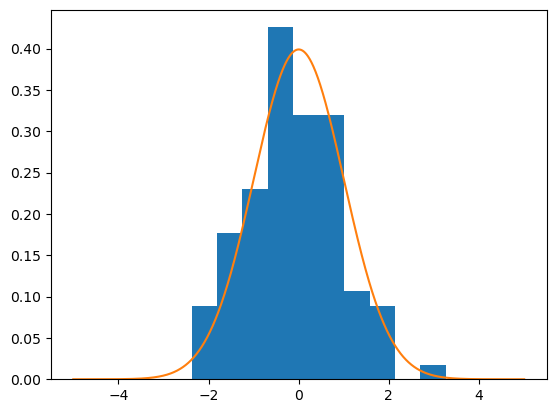

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

# a pymc context
with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    
    # define the tau of the prior
    tau0 = theta_prior_n*true_tau  
    
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    
    # this is the belief of the sum of squares
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    
    
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    # observed -> where the data enters the likelihood this is the only distribution that gets this
    #
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
    

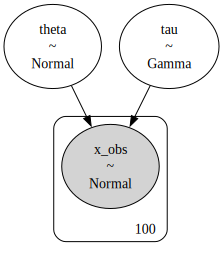

In [6]:
pymc.model_to_graphviz(conjugate_normal_gamma)
# the model just has two priors

In [7]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    tau      (chain, draw) float64 160kB 1.08 0.713 0.6993 ... 0.7681 0.9023
    theta    (chain, draw) float64 160kB -0.07615 -0.08663 ... 0.01407 -0.1186
Attributes:
    created_at:                 2025-02-08T16:14:47.447505+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              5.329568147659302
    tuning_steps:               100

In [10]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[-0.07615154, -0.08663012, -0.04325357, ..., -0.22095013,
         0.05943959, -0.11838345],
       [ 0.03788984, -0.08497942, -0.21806483, ..., -0.25387798,
         0.01406679, -0.11855212]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [11]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.08025911, 0.71300923, 0.69928629, ..., 0.98143797, 0.72430838,
        0.75769077],
       [0.80611101, 0.87367911, 0.74065338, ..., 0.88226284, 0.76813733,
        0.9022897 ]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

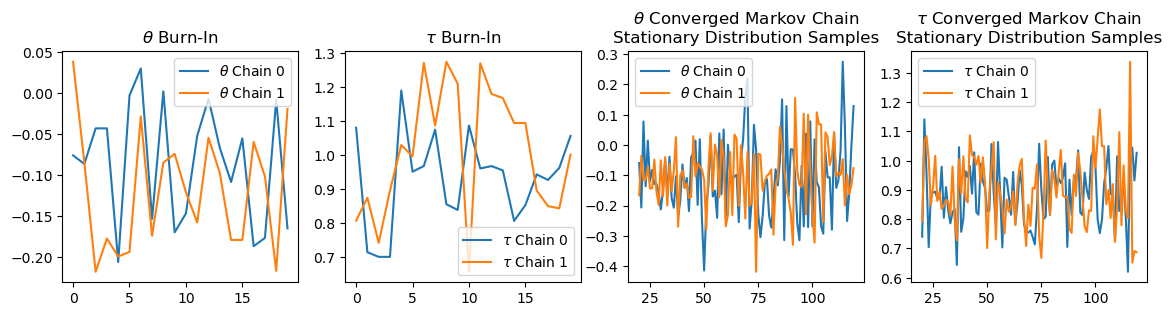

In [12]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

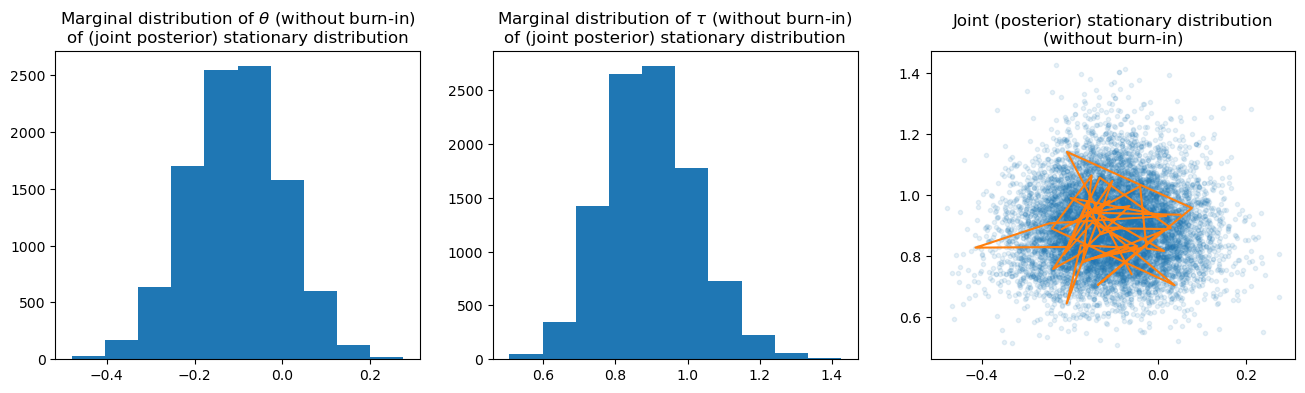

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [14]:
import arviz as az

In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

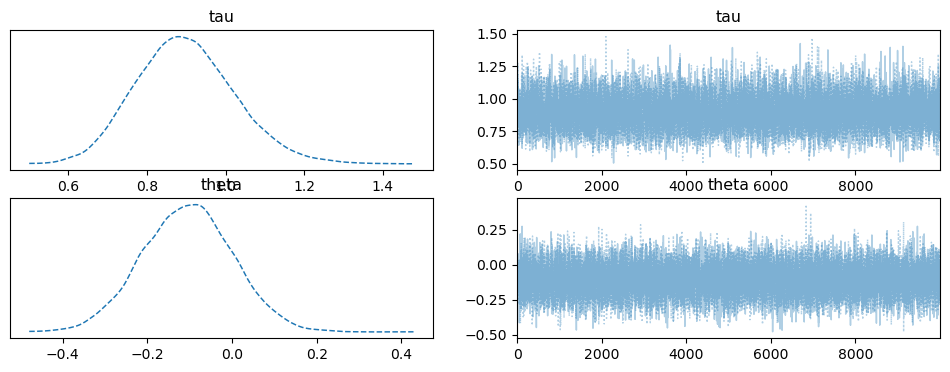

In [16]:
az.plot_trace(idata, combined=True);

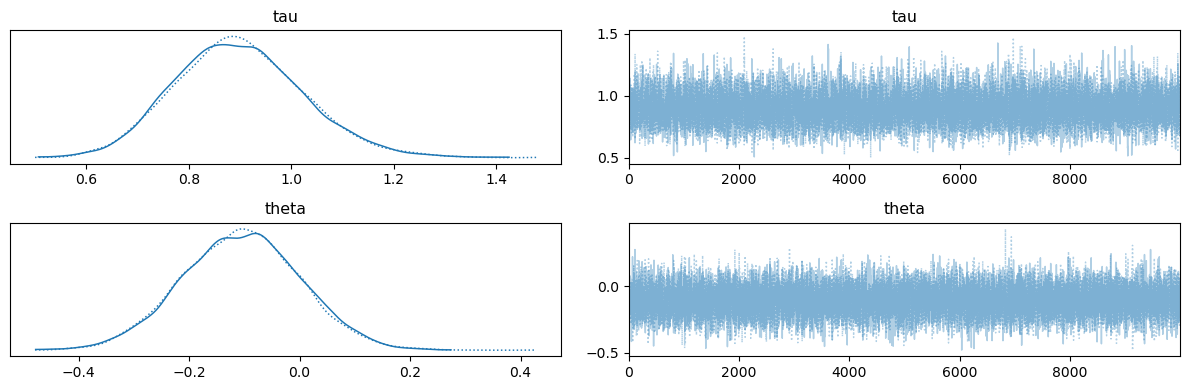

In [17]:
az.plot_trace(idata)
plt.tight_layout()

In [18]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

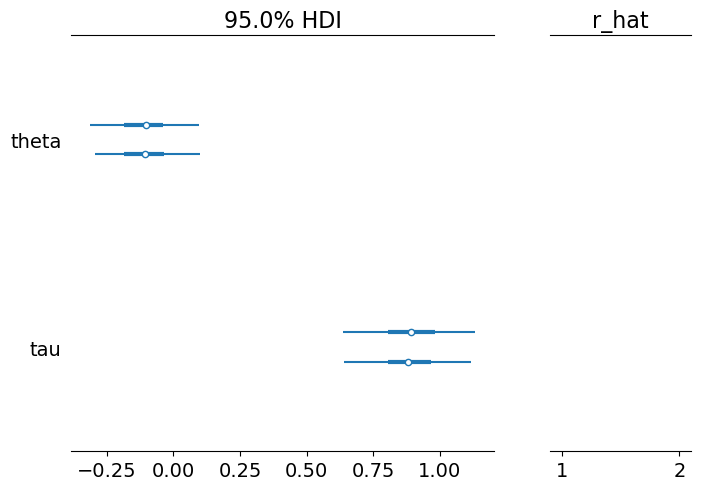

In [20]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [21]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

* mean is a monte-carlo estimate
* std dev is also a monte-carlo estimate based on the chain histogram
* hdi_3% = high density interval

In [22]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [23]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(-0.10761, 0.89236)

In [24]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.10589, 0.12898)

### `hdi_3%` and `hdi_97%`

In [25]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

In [26]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.27696,  0.06608])

In [27]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.30786,  0.09477])

In [28]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.29836,  0.08927])

In [29]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.32147,  0.07356])

In [30]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.65584, 1.12692])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [31]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

In [32]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.002449535132830938

In [33]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.0035870239673308894

In [34]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


1.2469657908119433e-07

In [35]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.00333555748996517

In [36]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.005224527008526711

In [37]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [38]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False]])

1724.2693996809026

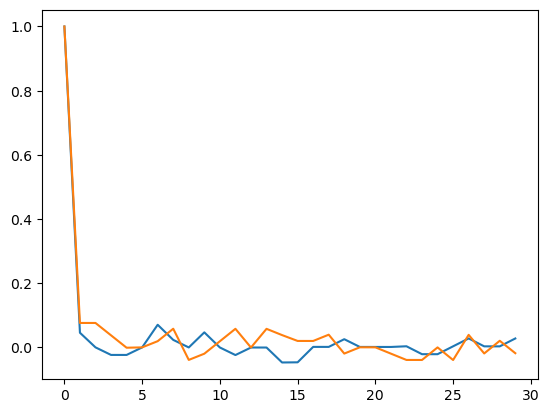

In [39]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [40]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  4.59119497e-02,  3.77108872e-04,
        -2.31929503e-02, -2.32409443e-02,  2.36436947e-04,
         7.07691019e-02,  2.36698561e-02,  9.48742243e-05,
         4.71073328e-02],
       [ 1.00000000e+00,  7.64252696e-02,  7.63713487e-02,
         3.78305346e-02, -7.14906772e-04,  2.92653886e-04,
         1.96482119e-02,  5.84208879e-02, -3.87147847e-02,
        -1.93584687e-02]])

In [41]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1117.7824133248555

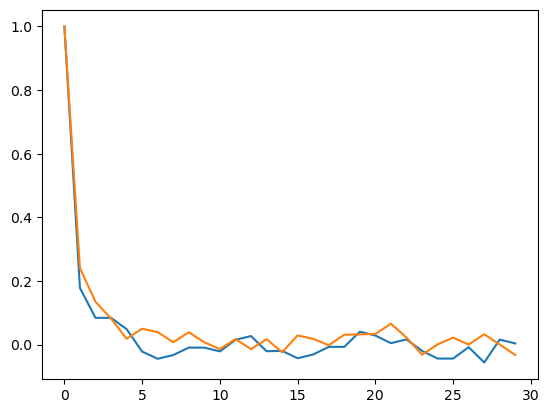

In [42]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [43]:
autocorrelations[:,:20]

array([[ 1.        ,  0.17797108,  0.08392958,  0.08383403,  0.04849743,
        -0.02209129, -0.04480048, -0.03310265, -0.00959426, -0.00970029,
        -0.02161736,  0.01490582,  0.02667303, -0.02091725, -0.01999086,
        -0.04306699, -0.03118484, -0.00730781, -0.00741373,  0.04046067],
       [ 1.        ,  0.24012762,  0.13448684,  0.08160219,  0.01814713,
         0.04970605,  0.03903196,  0.00723235,  0.03880063,  0.00699286,
        -0.01425766,  0.01731875, -0.01450391,  0.01707965, -0.02428635,
         0.02866806,  0.01793254, -0.0022996 ,  0.03084047,  0.03200527]])

In [44]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


1940.5979548299208

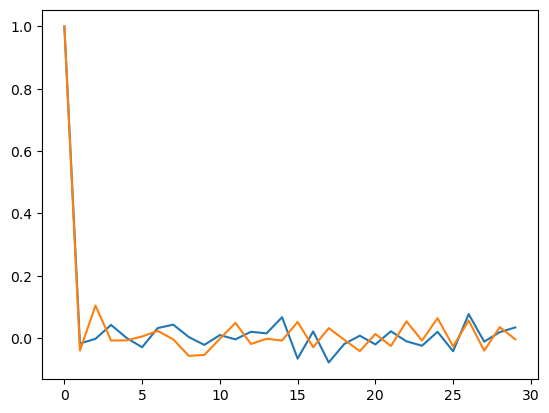

In [45]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [46]:
autocorrelations[:,:10]

array([[ 1.00000000e+00, -1.74997612e-02, -2.49492656e-03,
         4.21904595e-02,  3.67176637e-04, -2.95608004e-02,
         3.19544955e-02,  4.30420991e-02,  3.29396402e-03,
        -2.20467112e-02],
       [ 1.00000000e+00, -4.01997978e-02,  1.04288811e-01,
        -7.88010804e-03, -7.48955759e-03,  5.01254275e-03,
         2.30423866e-02, -4.16129660e-03, -5.71291282e-02,
        -5.43093237e-02]])

1360.317959886852

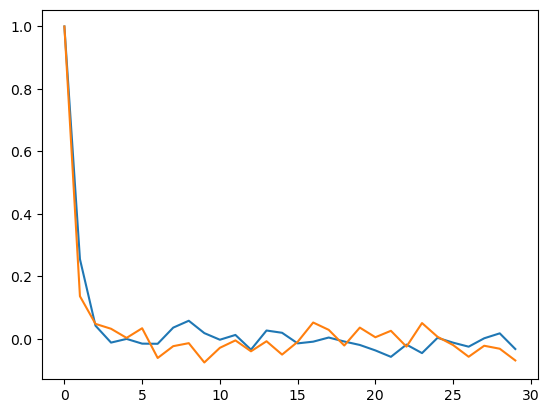

In [47]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [48]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  2.55030660e-01,  4.20394545e-02,
        -1.21421180e-02, -3.37086412e-04, -1.54820202e-02,
        -1.59649578e-02,  3.58046614e-02,  5.78109631e-02,
         1.82242144e-02],
       [ 1.00000000e+00,  1.36296905e-01,  4.78037855e-02,
         3.21603614e-02,  2.90513063e-03,  3.37892541e-02,
        -6.14338038e-02, -2.35874652e-02, -1.39568815e-02,
        -7.58019088e-02]])

In [49]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

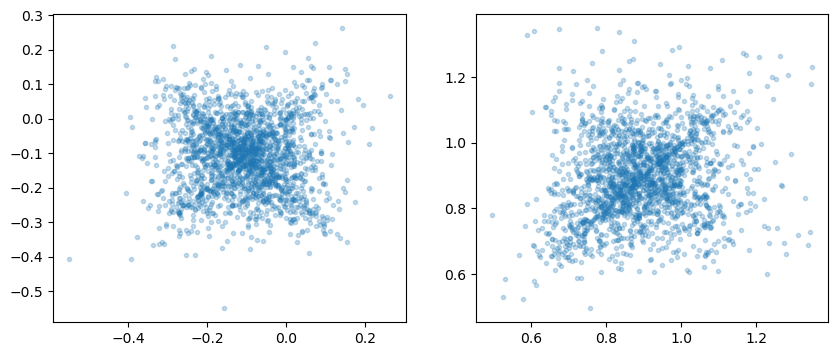

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [51]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.89236  0.12898  0.64972  1.11448    0.00355  0.00251  1292.93350   
theta -0.10761  0.10589 -0.29319  0.09258    0.00245  0.00198  1868.71276   

         ess_tail    r_hat  
tau    1156.79244  1.00125  
theta  1109.80127  1.00344

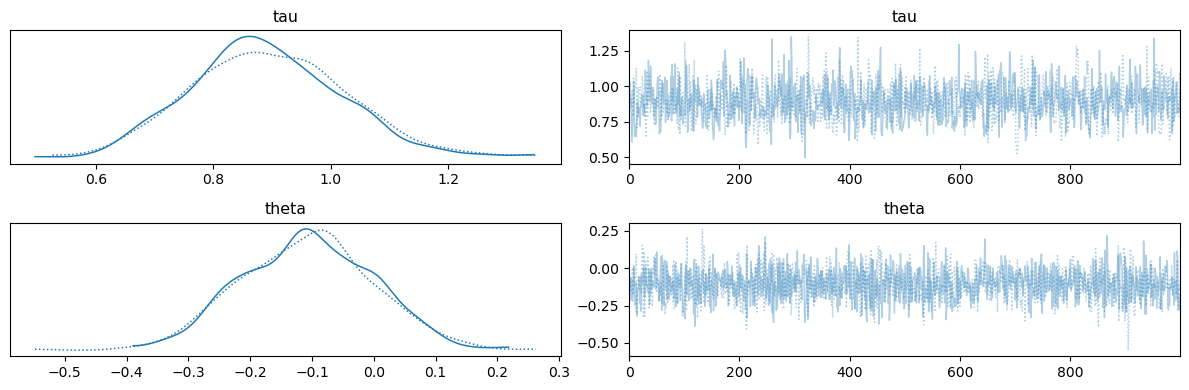

In [52]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


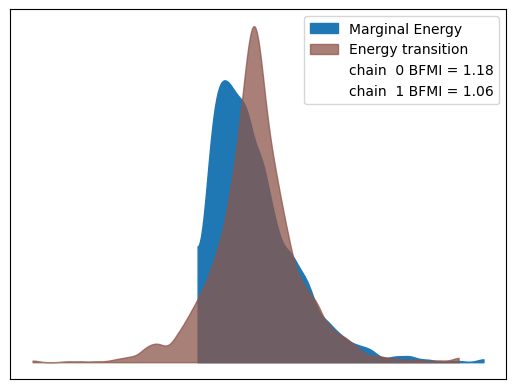

In [53]:
az.plot_energy(idata);

## Part D: Samplers


In [54]:
pymc.sample?

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.90  0.13    0.66     1.13        0.0      0.0   2114.59   2644.30   
theta -0.11  0.11   -0.30     0.10        0.0      0.0   2002.74   2365.82   

       r_hat  
tau      1.0  
theta    1.0

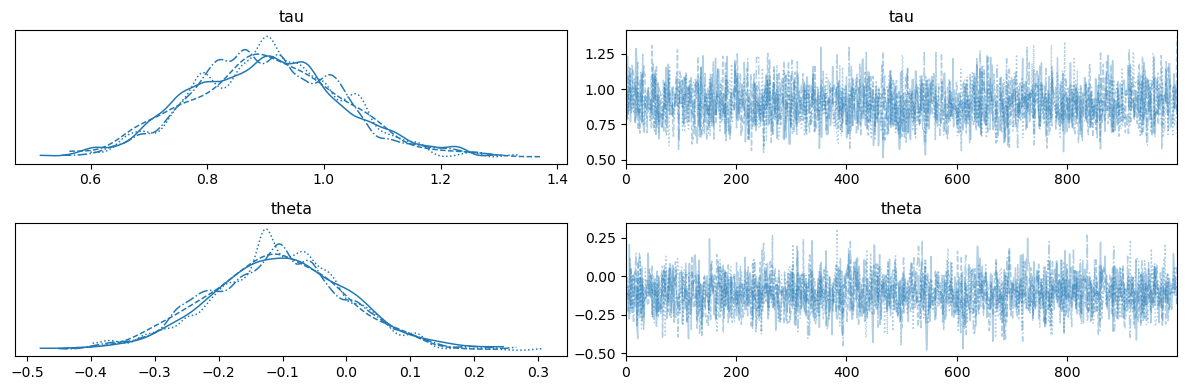

In [55]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [56]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.28228228, 0.41641642, 0.28128128, 0.35335335])

In [57]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.28228228, 0.41641642, 0.28128128, 0.35335335])

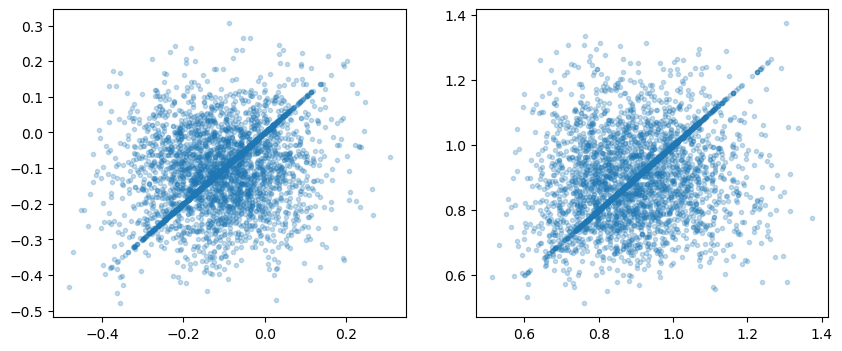

In [58]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.90  0.13    0.64     1.11        0.0      0.0   3709.98   2821.88   
theta -0.11  0.11   -0.32     0.08        0.0      0.0   3980.96   2794.77   

       r_hat  
tau      1.0  
theta    1.0

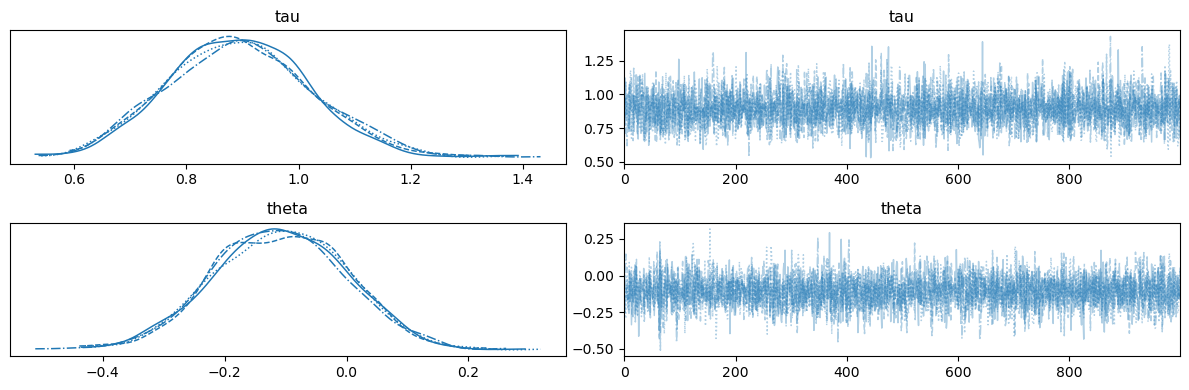

In [59]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [60]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

0         1         2         3         4         5         6    \
0  1.000000  0.982162  0.982688  1.000000  0.721625  0.845429  1.000000   
1  1.000000  0.829953  0.680089  0.877559  1.000000  0.758904  0.953380   
2  0.851936  0.915396  0.910845  0.998315  0.822325  0.995639  0.824132   
3  0.798763  0.935642  0.643124  0.943343  1.000000  0.736357  0.948350   

        7         8         9    ...       990       991       992       993  \
0  0.930300  0.834393  0.515333  ...  1.000000  0.998688  0.478041  1.000000   
1  0.973308  0.916550  0.925270  ...  0.999790  1.000000  0.978797  0.928354   
2  0.988354  0.933874  0.914362  ...  0.939134  1.000000  0.868849  1.000000   
3  0.894262  0.944933  0.942681  ...  1.000000  1.000000  0.722492  0.797212   

        994       995       996       997       998       999  
0  0.872788  1.000000  0.982277  0.894936  0.741041  0.980740  
1  0.929339  0.681427  0.769841  0.994768  0.934979  0.939133  
2  0.955096  1.000000  1.000000  0.984491  1.000000  0.946096  
3  0.895429  1.000000  0.899268  0.803602  0.956765  0.985767  

[4 rows x 1000 columns]

array([0.09846332, 0.09617715, 0.08810262, 0.09777005])

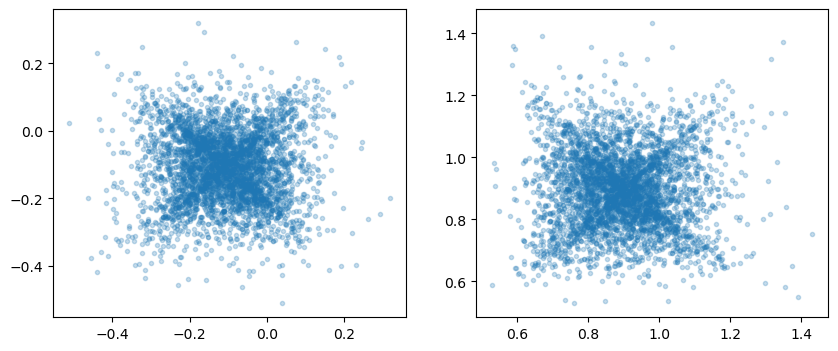

In [61]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta]
>Slice: [tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau     0.9  0.13    0.66     1.14        0.0      0.0   3875.19   2714.38   
theta  -0.1  0.11   -0.30     0.10        0.0      0.0   4333.59   2905.07   

       r_hat  
tau      1.0  
theta    1.0

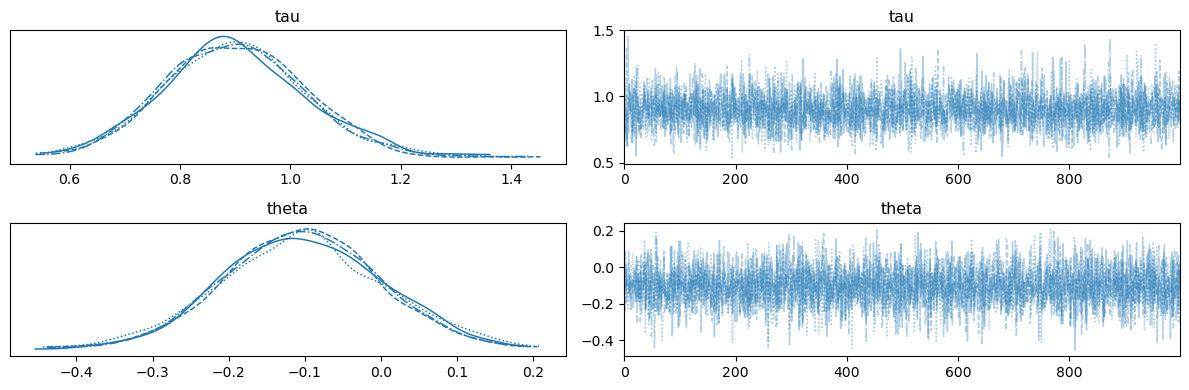

In [62]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [63]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [64]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

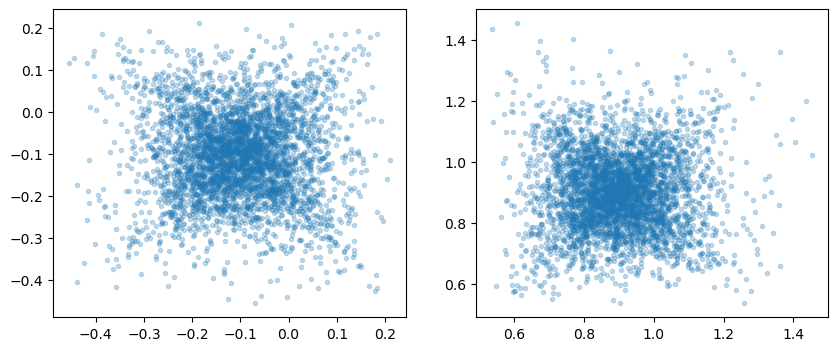

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.90  0.13    0.68     1.13       0.01      0.0    507.30    521.78   
theta -0.11  0.11   -0.31     0.09       0.01      0.0    392.46    457.57   

       r_hat  
tau     1.01  
theta   1.01

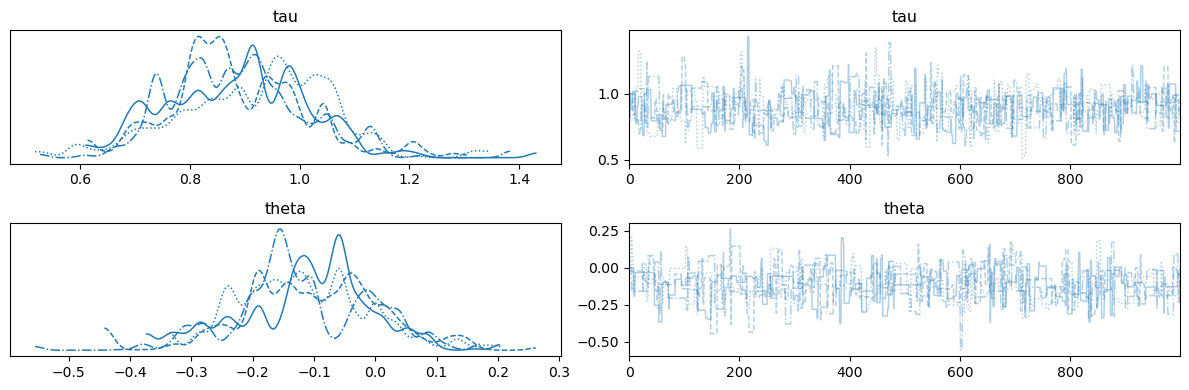

In [66]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [67]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.85785786, 0.86586587, 0.84984985, 0.86686687])

In [68]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.8028028 , 0.81181181, 0.83083083, 0.83183183])

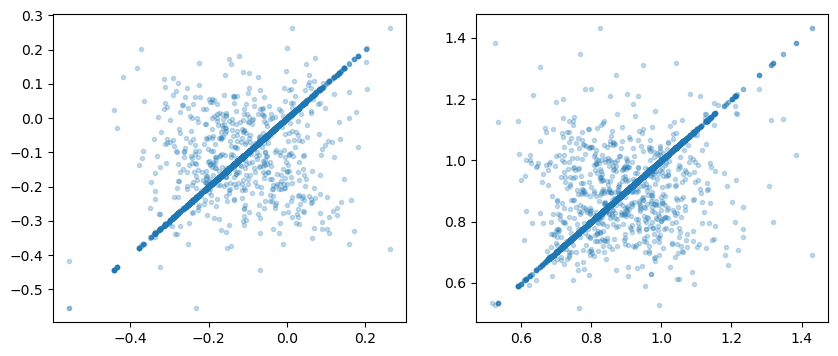

In [69]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.88  0.12    0.66     1.12       0.01      0.0    374.60    418.56   
theta -0.10  0.11   -0.30     0.10       0.01      0.0    414.07    491.67   

       r_hat  
tau     1.01  
theta   1.01

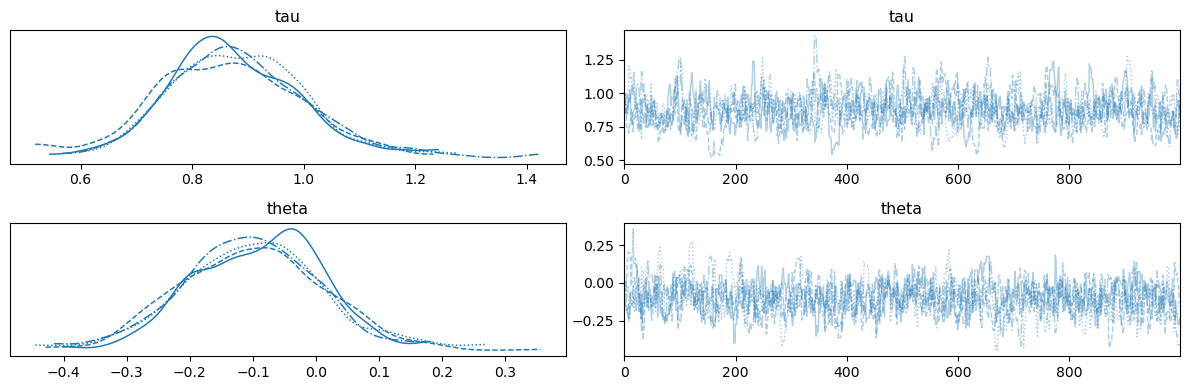

In [70]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [71]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.31431431, 0.27527528, 0.26626627, 0.26126126])

In [72]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.22322322, 0.22222222, 0.24124124, 0.2042042 ])

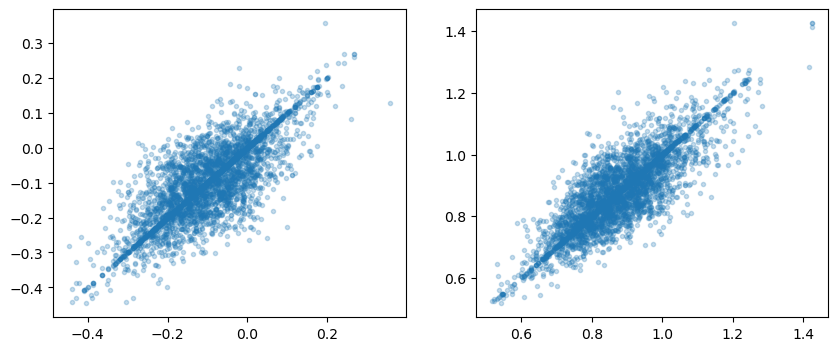

In [73]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- [Distribution Dimensionality](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html#dimensionality)
- [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html#pymc-pytensor)
- [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/acfb0536de4db53baddb8a6d632d6efdc65c01eedeee1a90b7b1e1dd45db4c16.svg)|![](https://www.pymc.io/projects/docs/en/stable/_images/8c363e9de8872b7ab545c203959bd5958fe2a55761ea45bc391ec893a51c4245.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/90f5f05f83d677cb540fc16bcf5962b15949b9cf531848fe6b20c02a7e271e24.svg)|

#### How to
- [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive)
- [Model comparison](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-comparison)
- [Updating Priors](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html)
- [Automatic marginalization of discrete variables](https://www.pymc.io/projects/examples/en/latest/howto/marginalizing-models.html)
- [How to debug a model](https://www.pymc.io/projects/examples/en/latest/howto/howto_debugging.html)
- [How to wrap a JAX function for use in PyMC](https://www.pymc.io/projects/examples/en/latest/howto/wrapping_jax_function.html)
- [Splines](https://www.pymc.io/projects/examples/en/latest/howto/spline.html)
- [Bayesian copula estimation: Describing correlated joint distributions](https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html)
- [Using ModelBuilder class for deploying PyMC models](https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html)
- [Using a “black box” likelihood function](https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html)
- [LKJ Cholesky Covariance Priors for Multivariate Normal Models](https://www.pymc.io/projects/examples/en/latest/howto/LKJ.html)
- [Bayesian Missing Data Imputation](https://www.pymc.io/projects/examples/en/latest/howto/Missing_Data_Imputation.html)
- [Profiling](https://www.pymc.io/projects/examples/en/latest/howto/profiling.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/docs/en/stable/_images/f6a6c1116b9f7cb6da212ccfc15a084c5a93885194033931d659fa0c272a23d3.png) | ![](https://www.pymc.io/projects/docs/en/stable/_images/220695e8447f0651dc133a3389ef5d6f586b78e08421f0a2371928118cc909f1.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/5c91b2b45e4e07be744bd90c92793f4b064b85ea9e147b0eaf3b463e1735f34a.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/36a3357f89d21ad98e89a8eef3179f83d6897f347714629d8ac8a85bd7100ad3.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/cd8d49dd3519e25c0ec2d3ef30a0816fe9c3f7708d9eda15d157590da6ca27b5.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/8db92b756eea453adc43232c1804b652adbb0c0cbad541338644a85ebdce8449.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/fc05f4904f9bc747ae16a7c7037f87b7dc39a480a2a24f0cff56f2ab9f1b9470.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/copula_schematic.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/bbc4da85106ec9c236813f170272c9b249e0a8af0911c428cddbf54bb0752c74.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/64c6c9c70b40b4cf651b5ad2b2b1b84a1e7e93a5ed67fac4355a38fcecf47024.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/f859e4ca959a1c0fc8f886a6752ef8317cff5016e94dc17a7c1cc6ac2cd9535f.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/c9989dd8511d1b594a2a82b778f8eea3617da7df1135c6bd3dd174a50acb4e2e.png) |


#### Generalized Linear Models
- [GLM: Robust Linear Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html)
- [GLM-ordinal-features](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-features.html)
- [Out-Of-Sample Predictions](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html)
- [Bayesian regression with truncated or censored data](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html)
- [Binomial regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-binomial-regression.html)
- [GLM: Negative Binomial Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html)
- [Hierarchical Binomial Model: Rat Tumor Example](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical-binomial-model.html)
- [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html)
- [GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-missing-values-in-covariates.html)
- [Regression Models with Ordered Categorical Outcomes](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html)
- [GLM: Poisson Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html)
- [Discrete Choice and Random Utility Models](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html)
- [GLM: Model Selection](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-model-selection.html)
- [GLM: Robust Regression using Custom Likelihood for Outlier Classification](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust-with-outlier-detection.html)
- [Rolling Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-rolling-regression.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/cca03e23e9627b2fb5f4156cb11fa372d2c3f72389827aa6cfb4f0503abc80ab.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/6ef5afd4f6618d3c0ed365a070e3a9ddea28b7ef7be11e7e131885f831f4ea37.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9101d5c4224baf8903f6f99c6d77f2758e5a6069d59d7782cf76b95c573f1049.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/833e85c397967de588409136ca9a0f916f3c8fe280acfe1897c235914af7a2be.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/416e190e3cba27b9495347b6b596b1c634994cf1b232c9b02da86c99b9e3d03c.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/15707fccc92da51bc592954d9b0db8e7507d02bb298a5060840b2681af815c9c.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/02876264b478027ad5229df6fd2030ad6b920fc7092a6c1802da60315485d3f5.png) | ![](https://www.cgenarchive.org/uploads/2/5/2/6/25269392/7758459_orig.jpg) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/39b62e02913b56f54c4c218aca75b41ef2510bb5a77d80c74a436d545d569b9b.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/bcfde70f4463aa317773d22138844a351017dcb759e243cbc046495501ac5e85.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/c2a7d0d9976f8423e0420f0ef0f22992f312119f6def0f7e9a3f6389be9e8e89.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/cdb7f44f2cfe84e2cc9a8e023c6db347f18f239b21ab8707d0b0c32520fd2c4f.svg) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/2abb4b985087a1a8d5f8dfa5b485b34f0134adcceb8cccb3fc9dc0f31ada9047.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/5435a742fd4cdea7455782b3bd158803caad25eb5f7a500a7e6bc84ce1415e72.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/6527831dd88c242e288d444e294f895c0a50eb792a59369a79e32f9290e5c959.png) |  |



#### Case Studies
- [Confirmatory Factor Analysis and Structural Equation Models in Psychometrics](https://www.pymc.io/projects/examples/en/latest/case_studies/CFA_SEM.html)
- [Hierarchical Partial Pooling](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html)
- [NBA Foul Analysis with Item Response Theory](https://www.pymc.io/projects/examples/en/latest/case_studies/item_response_nba.html)
- [Bayesian Estimation Supersedes the T-Test](https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html)
- [A Hierarchical model for Rugby prediction](https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html)
- [Estimating parameters of a distribution from awkwardly binned data](https://www.pymc.io/projects/examples/en/latest/case_studies/binning.html)
- [Factor analysis](https://www.pymc.io/projects/examples/en/latest/case_studies/factor_analysis.html)
- [Probabilistic Matrix Factorization for Making Personalized Recommendations](https://www.pymc.io/projects/examples/en/latest/case_studies/probabilistic_matrix_factorization.html)
- [Reliability Statistics and Predictive Calibration](https://www.pymc.io/projects/examples/en/latest/case_studies/reliability_and_calibrated_prediction.html)
- [Generalized Extreme Value Distribution](https://www.pymc.io/projects/examples/en/latest/case_studies/GEV.html)
- [Model building and expansion for golf putting](https://www.pymc.io/projects/examples/en/latest/case_studies/putting_workflow.html)
- [Fitting a Reinforcement Learning Model to Behavioral Data with PyMC](https://www.pymc.io/projects/examples/en/latest/case_studies/reinforcement_learning.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/aebe547ee33a40d30f0b8eee41e262900255ed6a7c431ab65a9927b9e13d1573.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/c723373ea236a4a93a129dff0c5864c0ceaa03f661ca396f00f58b9a81ee30da.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/4abeabe9deb44218a9e6d73a842a022ad50fabe0b589f95a58382542eb8c418d.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/18e7bca44fe93e19cfb553969bcca2fe136f68f43e96c718c517f036df6395ab.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/57717864299d85cf1955cf3751e75053d89e5663ae2d964ed7ac5726e92a14e7.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/c0cc0384a83306dbb27dddb3bbfe105636c84d850ee828b6daaf5059e3f02c03.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/d3902baec3a16548e994f270bd575d058f63b0919d3aad6bc4b5ab68e650e06d.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/2a3f02d521f5f6a8d895f7e14d46885d5fe5ef26709d695dc230a05c9e5378fa.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/c95e8d11d0f6644ec4cb69424b5b3445a79e8bd95fd6c0e1621beb65579231ec.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/2d9db3bdead58e8e7a75ad52ae71fd9fa637a42f4e666573ec730b496a828f3b.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/de0a5815e13aceba982d5a5e5de722affd9cc1e2042dcdcac7b18a286fd81fc6.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/1f0bd0030cbd99046a0e1230bd21c1ba8ca2879ef1c369c4fe96a72a1ea1cbcc.png) |



#### Causal Inference
- [Simpson’s paradox](https://www.pymc.io/projects/examples/en/latest/causal_inference/GLM-simpsons-paradox.html)
- [Interrupted time series analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html)
- [Regression discontinuity design analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/regression_discontinuity.html)
- [Interventional distributions and graph mutation with the do-operator](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html)
- [Bayesian Non-parametric Causal Inference](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_nonparametric_causal.html)
- [Bayesian mediation analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/mediation_analysis.html)
- [Counterfactual inference: calculating excess deaths due to COVID-19](https://www.pymc.io/projects/examples/en/latest/causal_inference/excess_deaths.html)
- [Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_ab_testing_introduction.html)
- [Difference in differences](https://www.pymc.io/projects/examples/en/latest/causal_inference/difference_in_differences.html)
- [Bayesian moderation analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/moderation_analysis.html)

| | | | |
|-|-|-|-|
| ![](https://upload.wikimedia.org/wikipedia/commons/f/fb/Simpsons_paradox_-_animation.gif) | ![](https://www.pymc.io/projects/examples/en/latest/_images/DAG_interrupted_time_series.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/regression_discontinuity.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9638b14b4bf42c43e4cadbdfb41fac3194fee21873f216397f28a85f4a70ea06.svg) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/78c4cc4e5fe406993c6d10bd6bc8e20b6962242f32dd1c00e037d0c10de92697.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/mediation.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/6801a496bcbc6c8599a92797e7cae13b1c2e6d03e7ab8cdd479feb7c8f5b76f8.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/df45924e1e38a6f758e57bc367e572f0b3f635b79ce5a2a9c9c7bcd3b0dbed07.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/DAG_difference_in_differences.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/2982eac5fa44000b39dbebc2a8d72b87692faa9b0f24032657814eb074ae89f8.png) | 


#### Gaussian Processes
- [Mean and Covariance Functions](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html)
- [Student-t Process](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-TProcess.html)
- [Heteroskedastic Gaussian Processes](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Heteroskedastic.html)
- [Gaussian Processes: Latent Variable Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html)
- [Sparse Approximations](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-SparseApprox.html)
- [Gaussian Processes using numpy kernel](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/gaussian_process.html)
- [Kronecker Structured Covariances](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Kron.html)
- [Example: Mauna Loa CO
continued](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)
- [Gaussian Process for CO2 at Mauna Loa](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html)
- [Gaussian Processes: HSGP Reference & First Steps](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html)
- [Baby Births Modelling with HSGPs](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Births.html)
- [Marginal Likelihood Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Marginal.html)
- [Multi-output Gaussian Processes: Coregionalization models using Hamadard product](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/MOGP-Coregion-Hadamard.html)
- [GP-Circular](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Circular.html)
- [Modeling spatial point patterns with a marked log-Gaussian Cox process](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/log-gaussian-cox-process.html)
- [Gaussian Processes: HSGP Advanced Usage](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Advanced.html)
- [Gaussian Process (GP) smoothing](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-smoothing.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/b32dad0edc3b59a6dc6f0da44044b002c11ab9c4e4995b8158637bd766cfad51.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/57d741d76e465f6e040f4201cf0118584e0b73b70924686ddb3da0fc338acb65.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/e232e7d9a039540fb24633a7463866eeab947212b87af65dc9535f55a659c463.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/3b8ca85a43537b6d641c239ae1c45c726f6c4fbe02a90043f0908c8cce9398d4.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/44ee9b965f3f214734360bd7c142334d7a48f4687d197c895a98099269289b02.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/b3e0033e0eb50e17e785e6a6e73ad21372b0c8dfc1ff73a86e34e9dd17e75f28.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9435fadf9974988d30272358b4362f3668eaf3d471533a2c5a524717d68ce709.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/ab459e8038c99d31e628b379749dec9ea060d002e8120e2ce304cc9d3a6cd951.png) |
| ![](http://sites.gsu.edu/geog1112/files/2014/07/MaunaLoaObservatory_small-2g29jvt.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/1b60fee59767da2f31bbbc437e1c4a5ef4a18065d3c4b6e0bd3fe5d2948523e6.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/dac71b44330f1844173b31a6e5886c3f05f44a7f8351d4bef7766a6dc0e5fd4a.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/2447e8ebbc842686109ae1c94a562490c64513eb6923e57e310fd86563d08d66.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/332521cd6ef8034362d2ef31059c06f5fec0b11b4908dae6091530fc5c7e79f4.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/6d6b411075905d18c7dd9d8a10c79a3a2e2b08203af2daaa4b1f31b355210963.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/b6c86a8daa0f88300d9775ace3f5d5908f43487ad9d6cd5418669d807bb91e09.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/649443f0ecb1ba943c4a8897aff5478de8d8cfa0717c9761e3a02de935961727.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/71744c45bcd7ccfa614abfc906318782c83d5a351633948f37d34e98a24c8584.png) | 


#### Time Series
- [Longitudinal Models of Change](https://www.pymc.io/projects/examples/en/latest/time_series/longitudinal_models.html)
- [Forecasting with Structural AR Timeseries](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html)
- [Analysis of An 
 Model in PyMC](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html)
- [Stochastic Volatility model](https://www.pymc.io/projects/examples/en/latest/time_series/stochastic_volatility.html)
- [Time Series Models Derived From a Generative Graph](https://www.pymc.io/projects/examples/en/latest/time_series/Time_Series_Generative_Graph.html)
- [Bayesian Vector Autoregressive Models](https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html)
- [Air passengers - Prophet-like model](https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html)
- [Multivariate Gaussian Random Walk](https://www.pymc.io/projects/examples/en/latest/time_series/MvGaussianRandomWalk_demo.html)
- [Inferring parameters of SDEs using a Euler-Maruyama scheme](https://www.pymc.io/projects/examples/en/latest/time_series/Euler-Maruyama_and_SDEs.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/e92b9c131b709dd3102a2bbda8a48ec4e31709504f4c74c002a97a6fba5b5619.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/a72e7a83bd44131c4c544f52c3de3fb4df7aaf7e9b41e35f5981c9868c69b765.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/58d7f2f82cfb880f1711815ffa168839d405b5c9e380a1eeafe1ba3f5995746c.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/6390028c025e1d66c40374fc3238fd8454cf661cd30a07a7e43fe34dc1cae992.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/42c93f0c8b71ae2145aab13ec45149fa83763c2416e282d54eefe36f2c4532ef.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/46db3979a328b9ac4ca045fdf34c75b2eb372ec81c2aa8d06daddab5b61b7c29.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9fa4b9c96f9f5f55740819d4b25db74ca0a8da4a40aab42c50e364b17ea2d31a.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/8abe419c7128e466c2389132486abf79812ecde35b96761bbae9164adca7afab.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/2b776f5df4e8a6fc9178a643b8931d320aaddec8810833d406577ab52256f51a.png) | 


#### Spatial Analysis
- [The Besag-York-Mollie Model for Spatial Data](https://www.pymc.io/projects/examples/en/latest/spatial/nyc_bym.html)
- [The prevalence of malaria in the Gambia](https://www.pymc.io/projects/examples/en/latest/spatial/malaria_prevalence.html)
- [Conditional Autoregressive (CAR) Models for Spatial Data](https://www.pymc.io/projects/examples/en/latest/spatial/conditional_autoregressive_priors.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/f9978a554480ea0aa2fb3ab3d68855b1bc7fd0b0956807394252b4c7d84a3b93.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9a3d6c1d8ed47be69f1b3078ee37ca120cd095b11677decc178011487d3dfb3f.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/b0c1efdbaa4abe2e3e02f1fbe1f807c3569663c0a631da625df25b897816bbe8.png) |  |


#### Diagnostics and Model Criticism
- [Bayes Factors and Marginal Likelihood](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html)
- [Diagnosing Biased Inference with Divergences](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
- [Sampler Statistics](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html)
- [Model Averaging](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/model_averaging.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/9ee9964c2412dbdb8b9c1fd52eed3de489c26d3171c3a95e08dbf033fd4e0e6e.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/33757c85f33ccb22eea1df664c7ecab53ce8f1f3c39608765a10c7b9bd943c04.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/09abca4e17fa1d1d6dced796912c117252af309bb2a0da104b4d06070c4f1376.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/04dfc13dad24652049eae900d067708b33c326a1cc0a809d54446806b8c88fe5.png) |


#### Bayesian Additive Regression Trees
- [Categorical regression](https://www.pymc.io/projects/examples/en/latest/bart/bart_categorical_hawks.html)
- [Bayesian Additive Regression Trees: Introduction](https://www.pymc.io/projects/examples/en/latest/bart/bart_introduction.html)
- [Modeling Heteroscedasticity with BART](https://www.pymc.io/projects/examples/en/latest/bart/bart_heteroscedasticity.html)
- [Quantile Regression with BART](https://www.pymc.io/projects/examples/en/latest/bart/bart_quantile_regression.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/491d8439fc5bab3dad1d1b899a574df74b53d460fafb63734c9171b11d3cc3b5.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/799c9ad4685dcfcd9174007a8904d3fb4151861c2e66f93005878b67d6bdd470.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/2a70660877b52a1474f190519f6d49f2a352f6ee88cc7578c0df40439f737732.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/fb1ceee1bf080b9b2898554db2ae70ddf1367040306c834e2c43a1a12f79d5bb.png) |


#### Mixture Models
- [Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/mixture_models/gaussian_mixture_model.html)
- [Dependent density regression](https://www.pymc.io/projects/examples/en/latest/mixture_models/dependent_density_regression.html)
- [Dirichlet process mixtures for density estimatio](https://www.pymc.io/projects/examples/en/latest/mixture_models/dp_mix.html)
- [Marginalized Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/mixture_models/marginalized_gaussian_mixture_model.html)
- [Dirichlet mixtures of multinomials](https://www.pymc.io/projects/examples/en/latest/mixture_models/dirichlet_mixture_of_multinomials.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/be9b6ee2d6c50c4472ef2968ae6fab25860073371be2aa29ebade1adf9952628.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/d394806a5d839fa0fa678227efd4e541486045dcdfb4a555b3749705848427b1.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/eb4d5d50b995d0b987d681aa0e77af7dc7061e01fcf76bc05a146b3b32f5fb52.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/0262971508f007212fa1dbaaf0a98eadbfecce02383a3133d7a89ed2bfcc0b72.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/6b6315d447e18b6a39f0f24deba8a847271570180c76af83e5ba6da8bc4eb6e6.png) | 


#### Survival Analysis
- [Reparameterizing the Weibull Accelerated Failure Time Model](https://www.pymc.io/projects/examples/en/latest/survival_analysis/weibull_aft.html)
- [Bayesian Survival Analysis](https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html)
- [Censored Data Models](https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html)
- [Frailty and Survival Regression Models](https://www.pymc.io/projects/examples/en/latest/survival_analysis/frailty_models.html)
- [Bayesian Parametric Survival Analysis](https://www.pymc.io/projects/examples/en/latest/survival_analysis/bayes_param_survival.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/56c22e18df74d52bb75350fb86f6f9dc0bef577572b4dcf3936d1aa39a307afe.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/faf356a8f5bf2a21353a56a90e7fea6f2795f67b40ca3f56c59ea8ebf91971dd.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/5d33add778ae781898173c0065c76cd136bc93722573ac843c9f89db0a03f7c2.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/b3e2c7af727f5d18818404da1643ee9302d42bb94b51a7e89c7d3ea73349da79.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/5ba010e4b0eb59d6a9c798094aa32aa4ea4622a8cffc30c32265a6e3cae3e649.png) |


#### ODE models
- [ODE Lotka-Volterra With Bayesian Inference in Multiple Ways](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html)
- [Lotka-Volterra with manual gradients](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_with_manual_gradients.html)
- [pymc3.ode: Shapes and benchmarking](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_API_shapes_and_benchmarking.html)
- [GSoC 2019: Introduction of pymc3.ode API](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_API_introduction.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/71f395975a2b788047b802bc081fe8dfd7c0427b4612a7d8fb24ba48d666934c.svg) | ![](https://www.pymc.io/projects/examples/en/latest/_images/0aadec0161029b521f232bf0b6337ac91197f5866b89336db2adcc63a5634aa0.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/f1d6ce0b93a1398ab102c7f009b8bf3fc988f78b54f650ccdf4b841fa78b2ea9.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/7774ceeaf7ca87d295b2921716ca9c43c4d094d1ba580111bcea6701cb4eb28e.png) |

#### MCMC
- [Lasso regression with block updating](https://www.pymc.io/projects/examples/en/latest/samplers/lasso_block_update.html)
- [Approximate Bayesian Computation](https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html)
- [DEMetropolis and DEMetropolis(Z) Algorithm Comparisons](https://www.pymc.io/projects/examples/en/latest/samplers/DEMetropolisZ_EfficiencyComparison.html)
- [Faster Sampling with JAX and Numba](https://www.pymc.io/projects/examples/en/latest/samplers/fast_sampling_with_jax_and_numba.html)
- [Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html)
- [Using a custom step method for sampling from locally conjugate posterior distributions](https://www.pymc.io/projects/examples/en/latest/samplers/sampling_conjugate_step.html)
- [DEMetropolis(Z) Sampler Tuning](https://www.pymc.io/projects/examples/en/latest/samplers/DEMetropolisZ_tune_drop_fraction.html)
- [Compound Steps in Sampling](https://www.pymc.io/projects/examples/en/latest/samplers/sampling_compound_step.html)


| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/2bc755fd8bf0a29be0c099502d53d2097de89708e8fd4c792426392f28773e1f.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/b3dd5f2e6168f27fbc43c4de6ac4a767b9e2843abcde4fc0ac6387024cfdd936.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/fd0c52f3aa065ef4a1a53be92edc2bda2b37c207975492919379200bef6faec4.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/a6200c084641fcdbddb8dcd934b79899a09357b22b12d743e338ae95127cf922.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/smc.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/aede7ed8b91855a9ffe4fdb579ab4658a52be9906f1364e0281e7af3831406de.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/914473e8d0a93efa73f7e8663a32bfa84b85adb927865a9205100e98ed535789.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/9b99971997f8422f63937e165d22cba0112e93c0a391029d803ba6fd0fa75e52.png) |


#### Variational Inference
- [Variational Inference: Bayesian Neural Networks](https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html)
- [Pathfinder Variational Inference](https://www.pymc.io/projects/examples/en/latest/variational_inference/pathfinder.html)
- [Empirical Approximation overview](https://www.pymc.io/projects/examples/en/latest/variational_inference/empirical-approx-overview.html)
- [Introduction to Variational Inference with PyMC](https://www.pymc.io/projects/examples/en/latest/variational_inference/variational_api_quickstart.html)
- [GLM: Mini-batch ADVI on hierarchical regression model](https://www.pymc.io/projects/examples/en/latest/variational_inference/GLM-hierarchical-advi-minibatch.html)

| | | | |
|-|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/cad6382102331ff90c2c382f63af66a7275b32896cbbb27e8ff1d4210c4118a6.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/077012558f2fe2e6b21854e6182b00e824a0d3a00e6df1688d13d20081a76027.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/1f492e57459477c94ea1c4592c256e74214136f337eb07f676f0f5899ce5fb3e.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/c9ab10539759da975aa8b8321f20f845e4fa74d348d913b339342682c4dd3aea.png) |
| ![](https://www.pymc.io/projects/examples/en/latest/_images/af9b90617fc072dcb41643f8d1228130d436ae7589248a7adcc8582793cf8ce3.png) | 



### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

# Q2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, precision]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, precision]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, precision]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         6.992  0.054   6.891    7.096      0.001    0.000    9192.0   
precision  2.347  0.267   1.877    2.863      0.003    0.002    9345.0   

           ess_tail  r_hat  
mu           6389.0    1.0  
precision    7294.0    1.0  
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         6.992  0.054   6.887    7.089      0.001    0.000   10953.0   
precision  2.309  0.268   1.804    2.802      0.003    0.002   10396.0   

           ess_tail  r_hat  
mu           7173.0    1.0  
precision    7158.0    1.0  
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         6.991  0.054   6.888    7.091      0.001    0.000   10436.0   
precision  2.359  0.278   1.858    2.894      0.003    0.002   10863.0   

           ess_tail  r_hat  
mu           6979.0    1.0  
precision    7381.0    1.0  


array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>,
        <Axes: title={'center': 'mu\n3'}>],
       [<Axes: title={'center': 'precision\n0'}>,
        <Axes: title={'center': 'precision\n1'}>,
        <Axes: title={'center': 'precision\n2'}>,
        <Axes: title={'center': 'precision\n3'}>]], dtype=object)

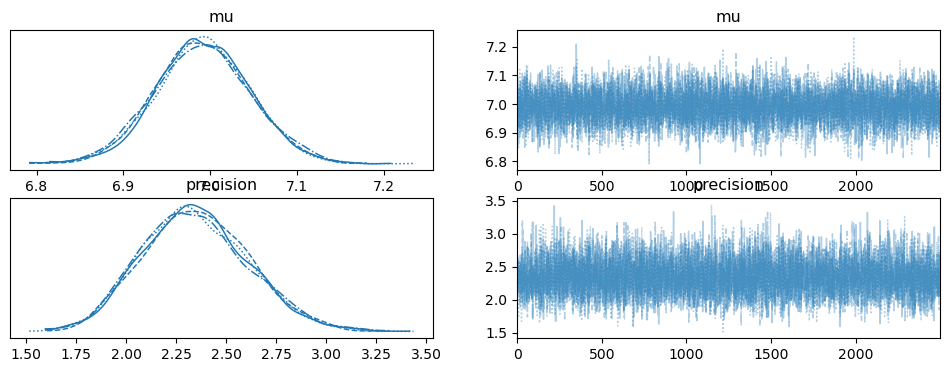

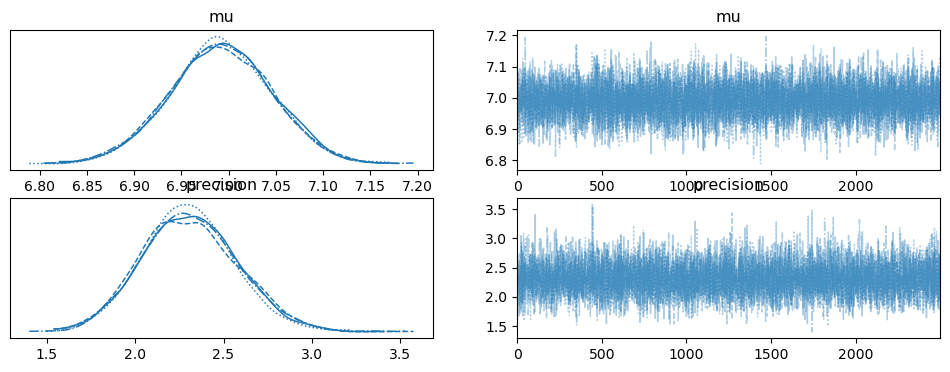

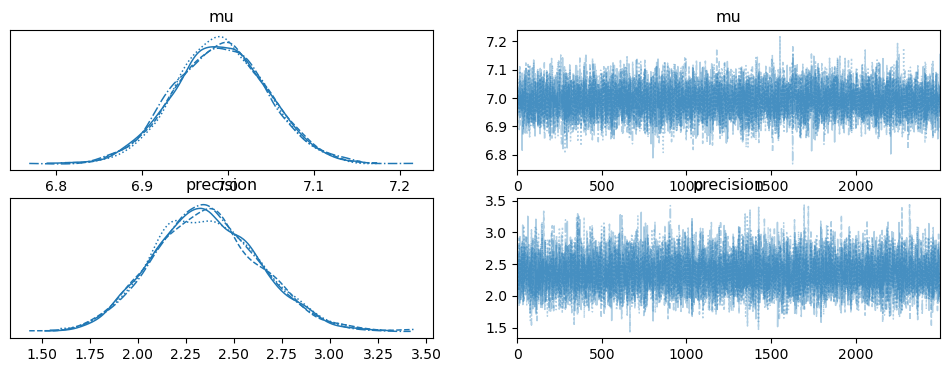

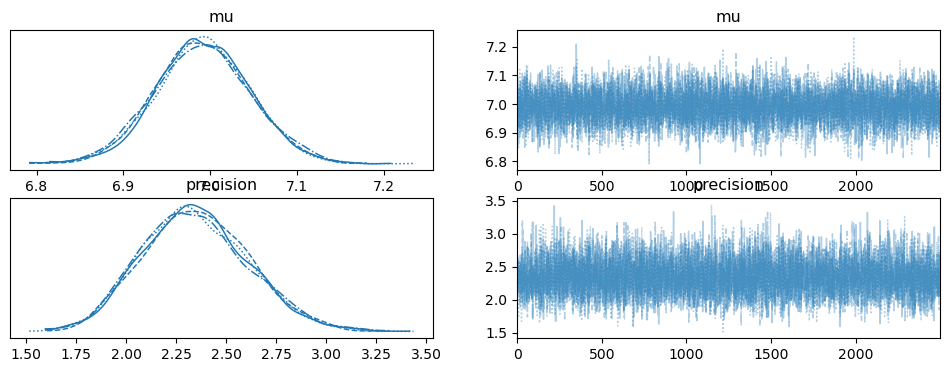

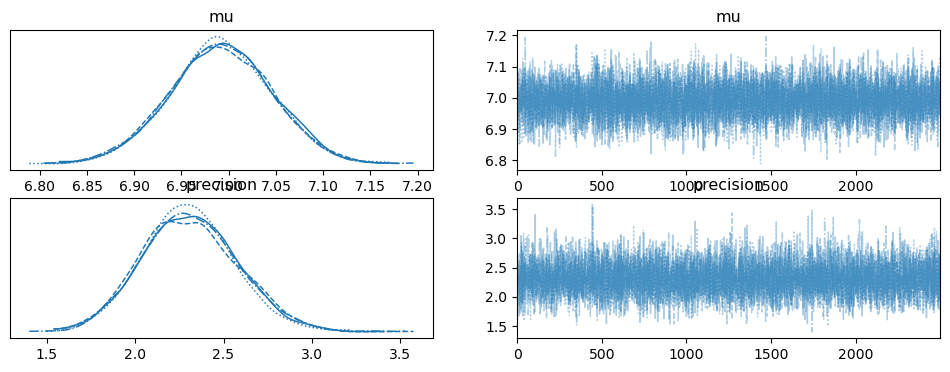

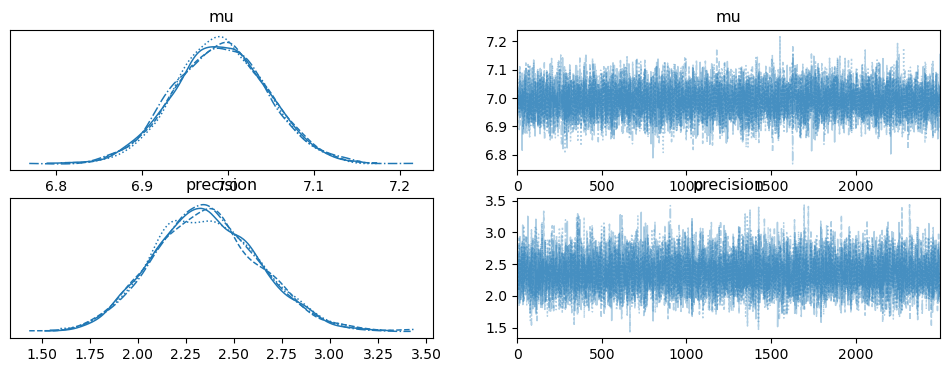

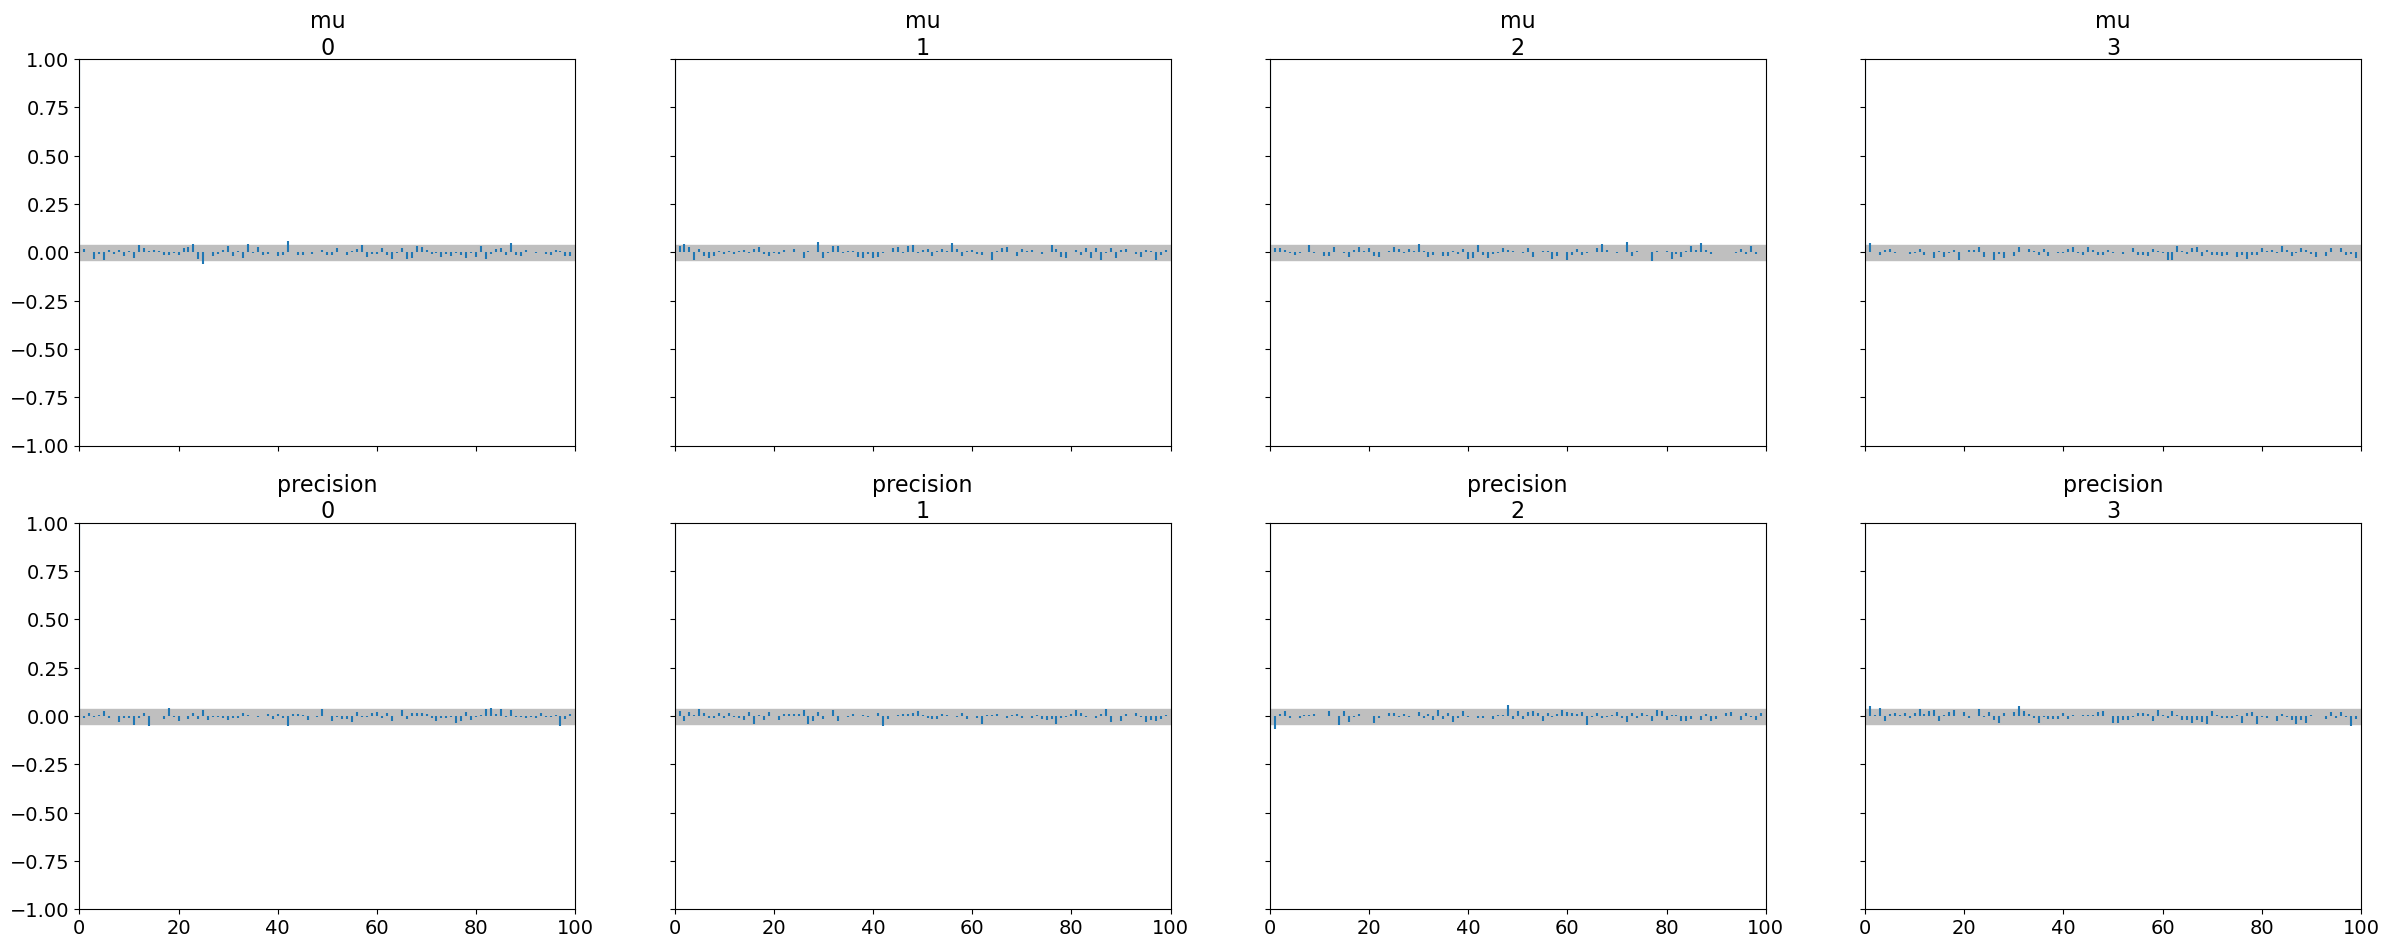

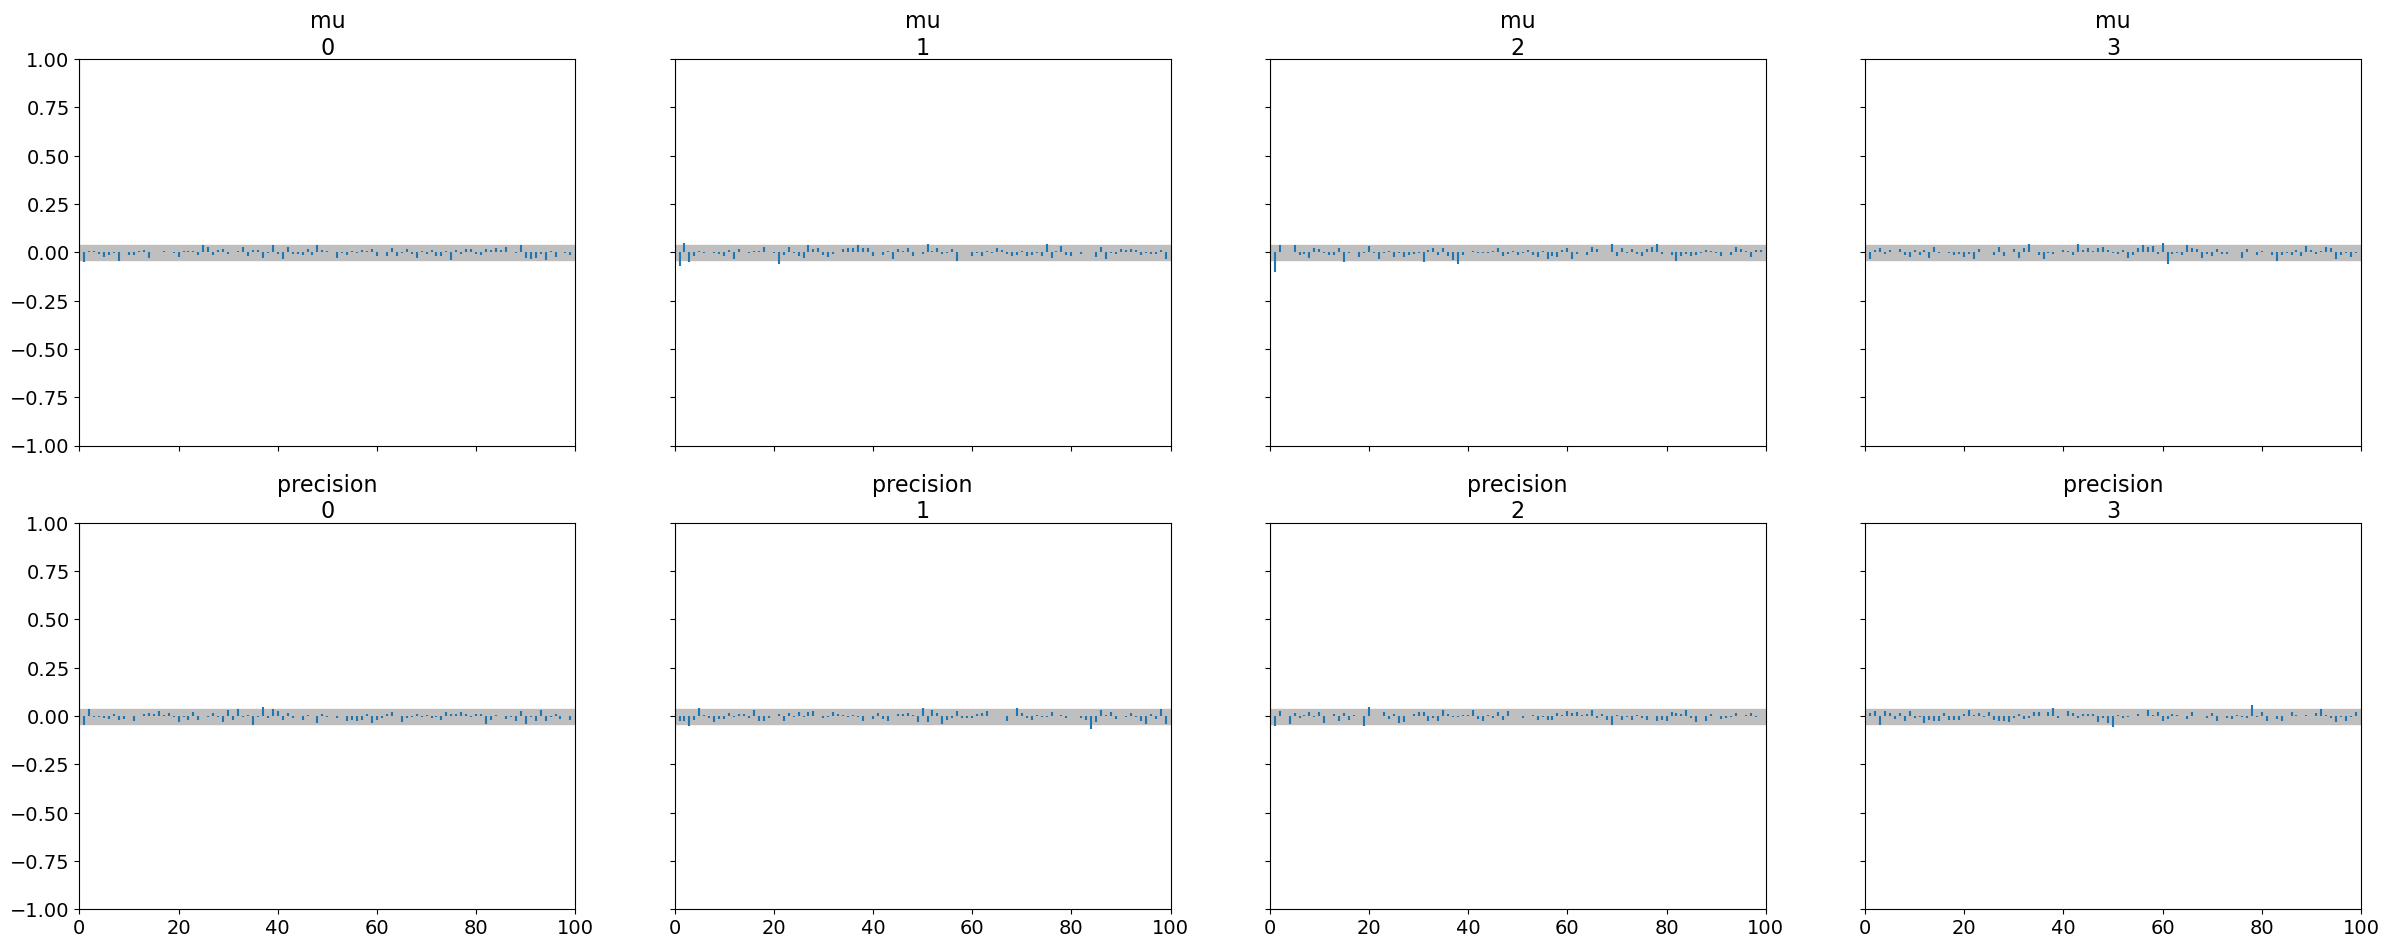

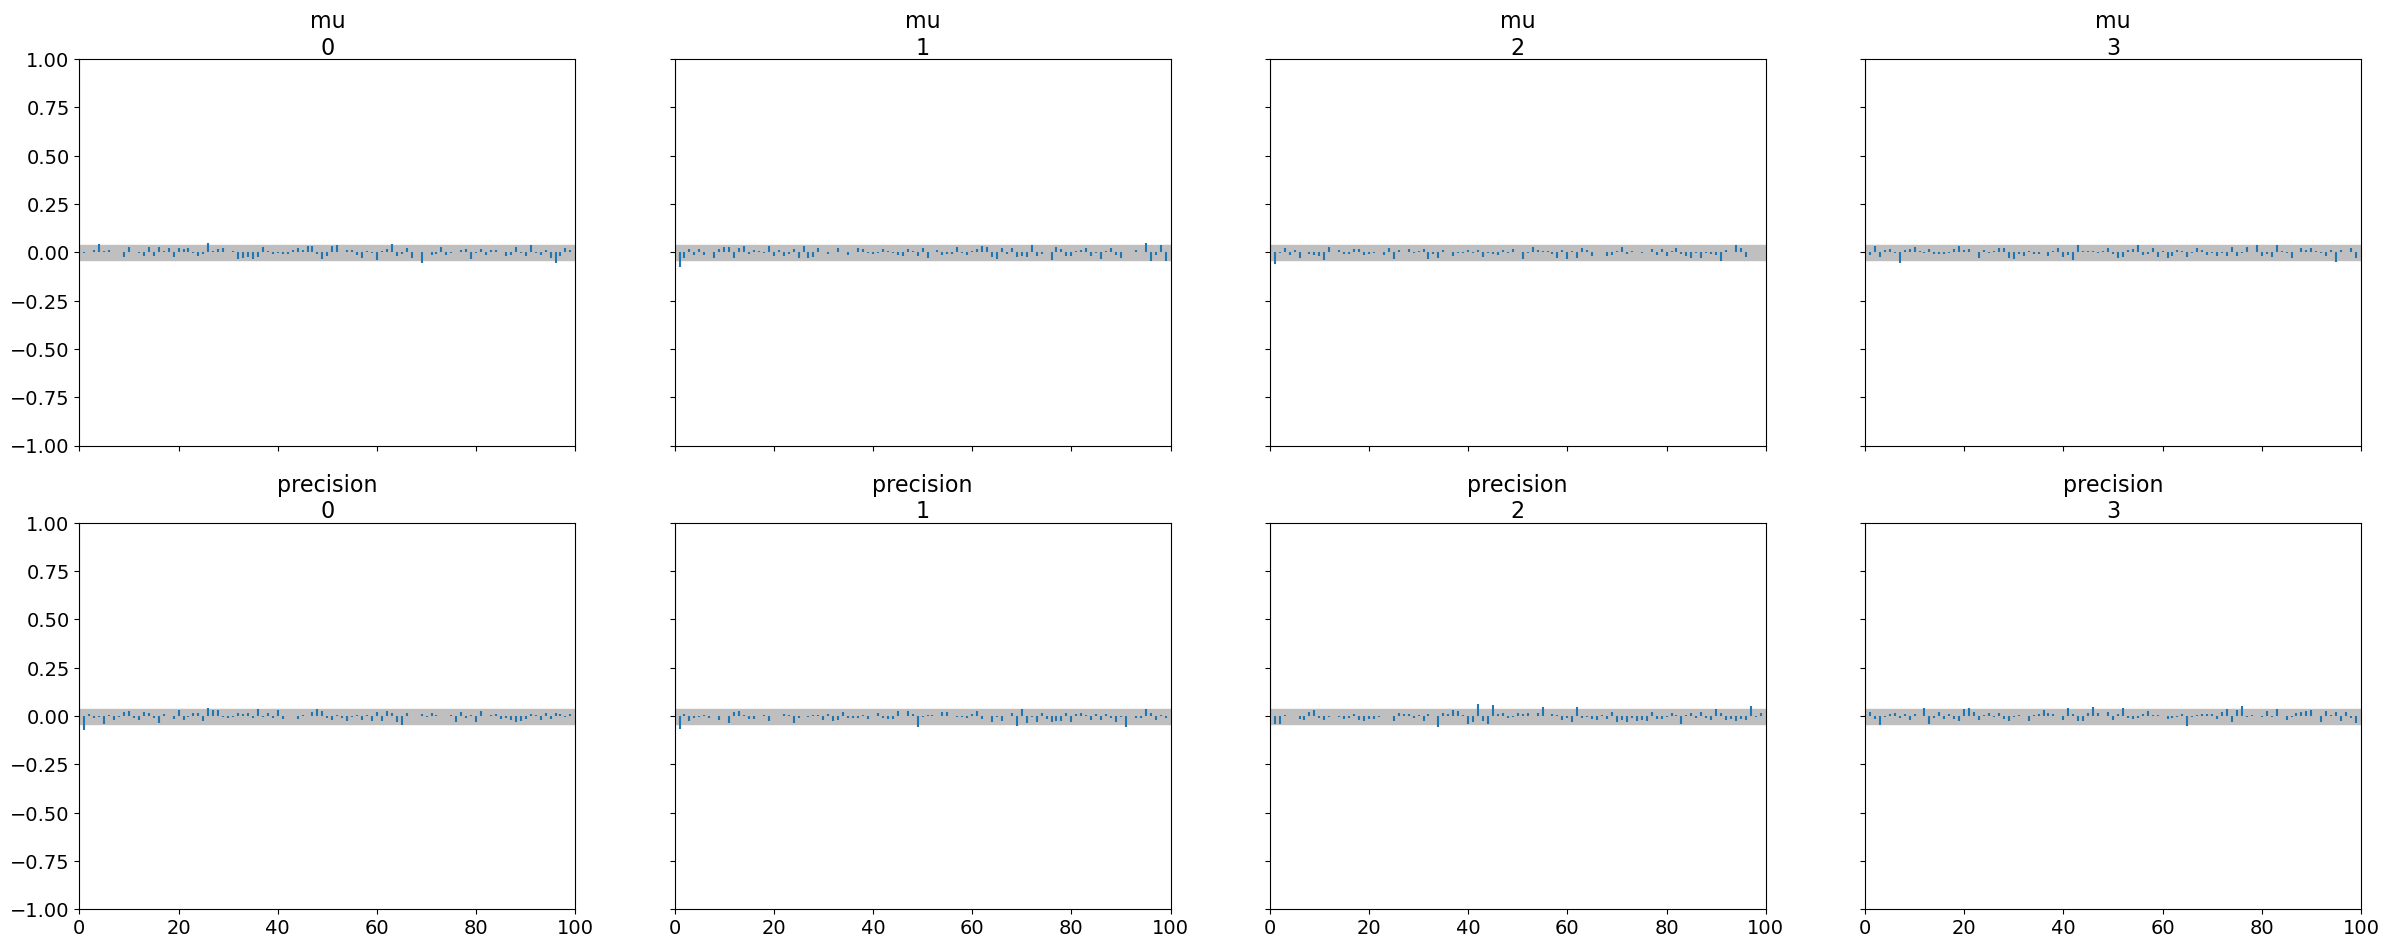

In [77]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(365)
n_samples = 150
true_mean = 7
true_precision = 2.3
data = np.random.normal(true_mean, 1 / np.sqrt(true_precision), n_samples)

# p1
with pm.Model() as model1:
    mu = pm.Normal("mu", mu=2, sigma=8)  
    precision = pm.Gamma("precision", alpha=3, beta=1.5)
    likelihood = pm.Normal("obs", mu=mu, tau=precision, observed=data)
    t1 = pm.sample(2500, return_inferencedata=True)

az.plot_trace(t1)
az.summary(t1)

# p2
with pm.Model() as model2:
    mu = pm.Uniform("mu", lower=3, upper=12) 
    precision = pm.Exponential("precision", lam=1.2)  
    likelihood = pm.Normal("obs", mu=mu, tau=precision, observed=data)
    t2 = pm.sample(2500, return_inferencedata=True)

az.plot_trace(t2)
az.summary(t2)

# p3
with pm.Model() as model3:
    mu = pm.Cauchy("mu", alpha=1, beta=4)
    precision = pm.LogNormal("precision", mu=0.5, sigma=1.2)
    likelihood = pm.Normal("obs", mu=mu, tau=precision, observed=data)
    t3 = pm.sample(2500, return_inferencedata=True)

az.plot_trace(t3)
az.summary(t3)

az.plot_trace(t1)
az.plot_trace(t2)
az.plot_trace(t3)

print(az.summary(t1))
print(az.summary(t2))
print(az.summary(t3))

az.plot_autocorr(t1)
az.plot_autocorr(t2)
az.plot_autocorr(t3)


# Q3

The Markov algorithm of slice sampling works by sampling a slice of the pdf $f(x)$ over an interval [a,b] to get a sequence of samples. First a sampling height is determined by getting a variable $y$ from a Uniform distribution so that it is in the area under $f(x)$. The interval is defined to be the area $f(x) > y$ which is where $x'$ is drawn. If $f(x')>y$ then the interval gets smaller until a new value is found. Due to this structue every new sample depends on the previous one.

In the code below we are sampling from is $f(x) = Beta(1.5, 3).pdf(x)$ and the intial value $x_0 = 0.25$. The curve represents the full conditional of $x$ and slice sampling makes sure we samplease from the area under this curve.

Slice sampling could be used instead of the Metropolis Hastings step when the full conditionals are known up to a normalizing constant. It will instead directly sample from the region by first initializing the Markov chain and doing slice sampling instead of MH for the variable $x_i$. Once this is done, continue to do the same for $x_{i+1}$ until the chain converges. This is done 

In [74]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


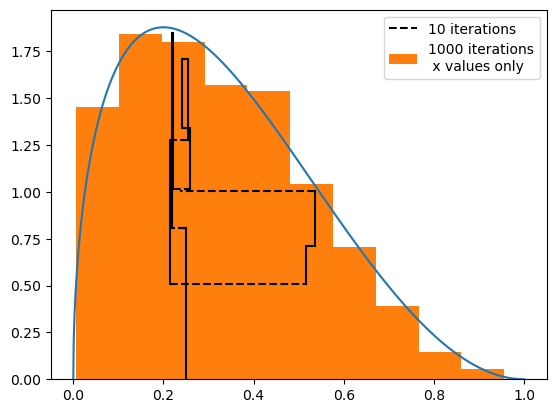

In [75]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();